In [12]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from joblib import Parallel, delayed

In [2]:
input_data = pd.read_csv('STORAGE_data/es-1min_FULL.csv')
input_data.index = pd.to_datetime(input_data.date + ' ' + input_data.time)
input_data

,date,time,open,high,low,close
2011-12-19 09:30:00,12/19/2011,9:30:00,1215.875,1216.375,1215.625,1215.875
2011-12-19 09:31:00,12/19/2011,9:31:00,1215.875,1217.125,1215.875,1217.125
2011-12-19 09:32:00,12/19/2011,9:32:00,1217.125,1217.875,1217.125,1217.625
2011-12-19 09:33:00,12/19/2011,9:33:00,1217.625,1218.375,1217.625,1218.125
2011-12-19 09:34:00,12/19/2011,9:34:00,1218.125,1218.375,1217.625,1217.875
...,...,...,...,...,...,...
2015-12-16 16:10:00,12/16/2015,16:10:00,2070.125,2070.375,2069.875,2070.125
2015-12-16 16:11:00,12/16/2015,16:11:00,2070.125,2070.875,2069.125,2069.250
2015-12-16 16:12:00,12/16/2015,16:12:00,2069.250,2072.125,2069.125,2072.125
2015-12-16 16:13:00,12/16/2015,16:13:00,2072.125,2072.625,2071.625,2072.000


In [3]:
data = input_data.drop(['date', 'time'], axis=1)

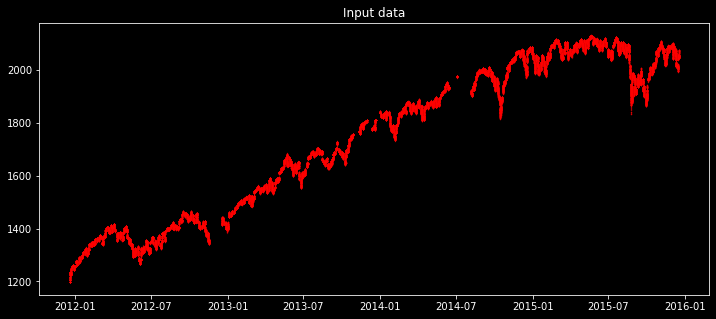

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(data.close, 'o', markersize=.3, color='red', alpha=.6)
plt.title('Input data')
plt.show()

In [84]:
def _start_duplicates_removing(inp_data):
    #   Clean duplicates
    ret_data = inp_data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    #   Check success of cleaning
    assert len(ret_data.index) == len(ret_data.index.unique())
    print(f'Duplicates at {1 - (ret_data.shape[0] / inp_data.shape[0]):.2%} of data')
    return ret_data

def normalize_data(inp_data: pd.DataFrame, show=True):
    #   Calculate the right numbers of observations intra day
    NORMAL_MINUTES = (15 - 9) * 60 + 59 - 29
    #   Checks for duplicates
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(12,8))
        plt.subplot(2,1,1)
        plt.plot(inp_data.close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Input data')

    if len(inp_data.index) != len(inp_data.index.unique()):
        inp_data = _start_duplicates_removing(inp_data)
    #   In data not of all information about trade-day. For example at date 2011-12-19 data ends at 15:59. At date 2015-12-19 data ends at 16:14. Notice that normal trade day ends at 16:30.
    #   At start lets drop lines with days with zero observations.
    mask = ~np.in1d(inp_data.index.date,inp_data.resample('1D').count().query(f'open < {NORMAL_MINUTES}').index.date)

    if show:
        plt.subplot(2,1,2)
        plt.plot(inp_data.loc[mask,:].close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Cut data')
        plt.show()
    #   Shows percent of "bad" dotes
    print(f"Bad days at {1 - (len(mask) / len(inp_data)):.2%} observations")
    return inp_data.loc[mask,:]


np.random.seed(124)
sample_size = 100000
scalar = 100

def _hurst_estimate_time_lag(time_lag, inp_data):
    """
    Return mean_RS on input_batch
    :param time_lag: time_lag
    :param inp_data: input_data
    :return: meanRS calculates like mean of R/S array on input_data splited into d batches d == len(inp_data) // time_lag
    """
    #   Create batches with length == time_lag. Into this batches we will calculate R/S parameter and then take mean of R/S array
    number_of_sub_series = len(inp_data) // time_lag
    R_array = list()
    S_array = list()
    for sub_serial in range(0, number_of_sub_series):
        buffer_data = inp_data[sub_serial * time_lag:(sub_serial + 1) * time_lag]
        #   This dumb way sry..
        if len(buffer_data) == 0:
            break
        buffer_mean = np.nanmean(buffer_data)
        normalized = np.subtract(buffer_data, buffer_mean)
        cumulative_normalized = np.cumsum(normalized)
        #   In formula ddof=0 but i'm not sure that this is correct (Previously we calculate mean so...)
        standard_deviation = np.nanstd(buffer_data, ddof=0)
        R_array.append(max(cumulative_normalized) - min(cumulative_normalized))
        S_array.append(standard_deviation)
    mean_RS = np.nanmean(np.divide(R_array, S_array))
    return mean_RS

def _hurst_runner(inp_data, HYPERPARAM_0, ANIS_LLOYD):

    Q_ARRAY = [2 ** q for q in range(1, int(np.log2(len(inp_data)) / HYPERPARAM_0))]
    #print(Q_ARRAY)
    #M = len(inp_data) / 2
    #Q_ARRAY = [q for q in range(5, int(M / HYPERPARAM_0), int(M / HYPERPARAM_0) // 10)]
    #Q_ARRAY = [2 ** q for q in range(1, int(np.log(len(inp_data))))]
    RS_ARRAY = list()

    for _ in Q_ARRAY:
        RS_ARRAY.append(_hurst_estimate_time_lag(_, inp_data))

    Q_ARRAY = Q_ARRAY[1:]
    RS_ARRAY = RS_ARRAY[1:]
    if not ANIS_LLOYD:
        POLYFIT = np.polyfit(np.log(Q_ARRAY), np.log(RS_ARRAY), deg=1)
    if ANIS_LLOYD:
        ALC = list()
        for ABC in Q_ARRAY:
            if ABC <= 340:
                ALC.append(gamma((ABC - 1) / 2) * np.sum([np.sqrt((ABC - i) / i) for i in range(1, ABC -1)]) / (np.sqrt(np.pi) * gamma(ABC / 2)))
            if ABC > 340:
                ALC.append(np.sum([np.sqrt((ABC - i) / i) for i in range(1, ABC -1)]) / np.sqrt(ABC * np.pi / 2))
        POLYFIT = np.polyfit(np.log(Q_ARRAY), np.log(RS_ARRAY) - np.log(ALC) + np.log(Q_ARRAY) / 2, deg=1)
    # print(f'FOR sample_len={HYPERPARAM_0} MAX Q = {Q_ARRAY[-1]}\nn * {POLYFIT[0]} + {POLYFIT[1]}\n================')
    #print(f'FOR LAG Q={Q_ARRAY[-1]} HURST EXPONENT={POLYFIT[0]}')
    return POLYFIT[0], POLYFIT[1], Q_ARRAY[-1]

def hurst_optimizer(inp_data, ANIS_LLOYD=False, simplify=1):

    def use_hurst_runner(HYPER):
        CF_a, CF_b, Q = _hurst_runner(inp_data, HYPERPARAM_0=HYPER, ANIS_LLOYD=ANIS_LLOYD)
        return [CF_a, CF_b, Q]

    plt.figure(figsize=(12,6))
    plt.title('Hard')
    #inp_data = np.log(inp_data)
    inp_data = np.diff(inp_data) / inp_data[:-1]
    #for HYPER in range(int(np.log(len(inp_data)) / 2), 1, -1):
    # for HYPER in tqdm(np.arange(4,1.5,-0.2 * simplify)):
    #     CF_a, CF_b, HYPERMARAM = _hurst_runner(inp_data, HYPERPARAM_0=HYPER, ANIS_LLOYD=ANIS_LLOYD)
    #     plt.plot((2 ** int(np.log2(len(inp_data)) / HYPER)), CF_a,  'o', color='blue', markersize=2, alpha=.7)
    #     return [CF_a, CF_b, HYPERMARAM]
    #HYPER_ARRAY = np.arange(4,1.5,-0.2 * simplify)
    HYPER_ARRAY = np.arange(5,1.5,-0.2 * simplify)
    results = Parallel(n_jobs=-1, verbose=10)(delayed(use_hurst_runner)(HYPER) for HYPER in HYPER_ARRAY)
    #for i, CF in enumerate(results):
    #    plt.plot(CF[2], CF[0], 'o', color='blue', markersize=2, alpha=.7)
    plt.plot([_[2]for _ in results[1:]], [_[0]for _ in results[1:]], '--', color='white')
    return results

Duplicates at 6.18% of data
Bad days at 100.00% observations


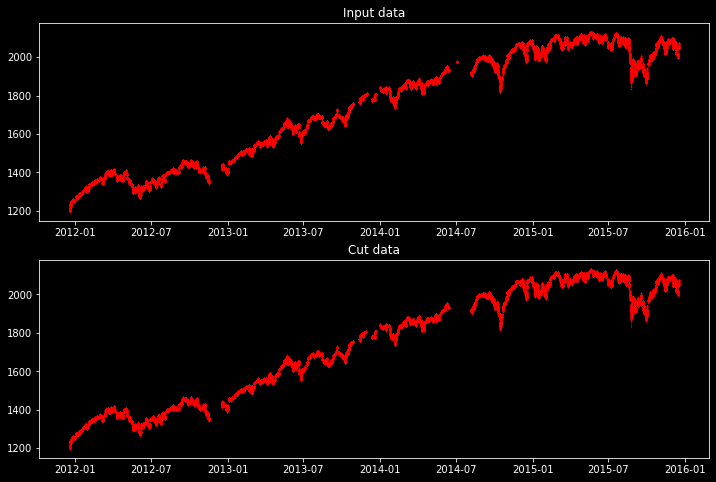

In [6]:
nrm = normalize_data(data).close.values

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/1153177317.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/1153177317.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/1153177317.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/1153177317.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/1153177317.py:97: RankWarning: Polyfit may be poorly conditioned
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  3.1min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  3.1min remaining:  3.9min
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/1153177317.py

[[0.17955633173501853, 0.2489179301876287, 4],
 [0.6503847173953068, -0.40378880590840976, 8],
 [0.6503847173953068, -0.40378880590840976, 8],
 [0.6503847173953068, -0.40378880590840976, 8],
 [0.6295678895752027, -0.3701208463810938, 16],
 [0.6091586878525906, -0.33239663136373976, 32],
 [0.5924865419550334, -0.297727878595411, 64],
 [0.5805145372298679, -0.270066674192416, 128],
 [0.5630770793883808, -0.2239443728427465, 512]]

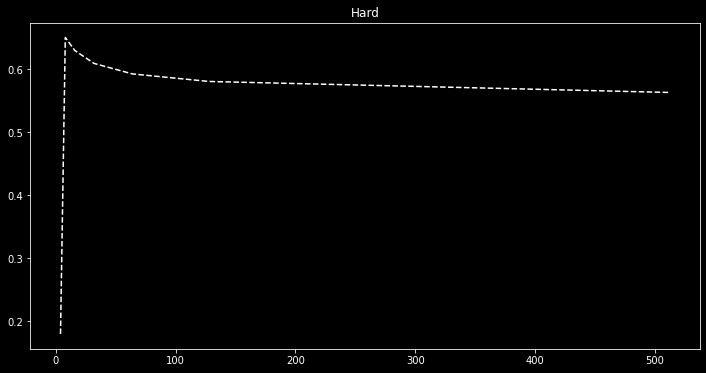

In [85]:
hurst_optimizer(nrm, simplify=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/367780473.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/367780473.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/367780473.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/367780473.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/367780473.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/367780473.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/367780473.py:63: RuntimeWarning:

[[0.6503845965424878, -0.40379100816964764, 4.0],
 [0.6503845965424878, -0.40379100816964764, 3.8],
 [0.6295681032173202, -0.3701235896355169, 3.5999999999999996],
 [0.6295681032173202, -0.3701235896355169, 3.3999999999999995],
 [0.6295681032173202, -0.3701235896355169, 3.1999999999999993],
 [0.6091595628826891, -0.33240059712273423, 2.999999999999999],
 [0.6091595628826891, -0.33240059712273423, 2.799999999999999],
 [0.5924872673953054, -0.29773153329110624, 2.5999999999999988],
 [0.5924872673953054, -0.29773153329110624, 2.3999999999999986],
 [0.5805168862944353, -0.27007408025678675, 2.1999999999999984],
 [0.5708909760557468, -0.24560944760179593, 1.9999999999999982],
 [0.5630821095697705, -0.2239586724493007, 1.799999999999998],
 [0.5557945497435377, -0.20206948241353706, 1.5999999999999979]]

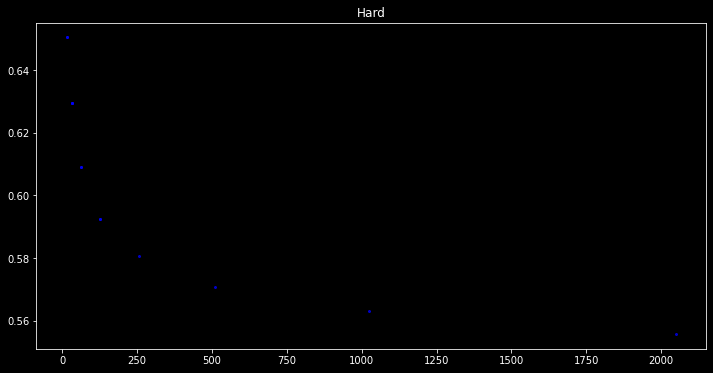

In [27]:
hurst_optimizer(nrm, simplify=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/2505727004.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/2505727004.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/2505727004.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/2505727004.py:63: RuntimeWarning: invalid value encountered in true_divide
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/2505727004.py:97: RankWarning: Polyfit may be poorly conditioned
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/2505727004.py:97: RankWarning: Polyfit may be poorly conditioned
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2962/2505727004.py:63: RuntimeWarning: invalid valu

[[0.31705939864164334, 0.4395376564769738, 5.0],
 [0.31705939864164334, 0.4395376564769738, 4.8],
 [0.27470483750214036, 0.49825354575237457, 4.6],
 [0.27470483750214036, 0.49825354575237457, 4.3999999999999995],
 [0.27470483750214036, 0.49825354575237457, 4.199999999999999],
 [0.27470483750214036, 0.49825354575237457, 3.999999999999999],
 [0.27470483750214036, 0.49825354575237457, 3.799999999999999],
 [0.3579141824191565, 0.3636754591596115, 3.5999999999999988],
 [0.3579141824191565, 0.3636754591596115, 3.3999999999999986],
 [0.3579141824191565, 0.3636754591596115, 3.1999999999999984],
 [0.3990601663929337, 0.28762153173884275, 2.9999999999999982],
 [0.3990601663929337, 0.28762153173884275, 2.799999999999998],
 [0.42313709841159053, 0.23755495910304744, 2.599999999999998],
 [0.42313709841159053, 0.23755495910304744, 2.3999999999999977],
 [0.4402271876343522, 0.19806846856879595, 2.1999999999999975],
 [0.45241246433587956, 0.16709910453877305, 1.9999999999999973],
 [0.46175070926256423

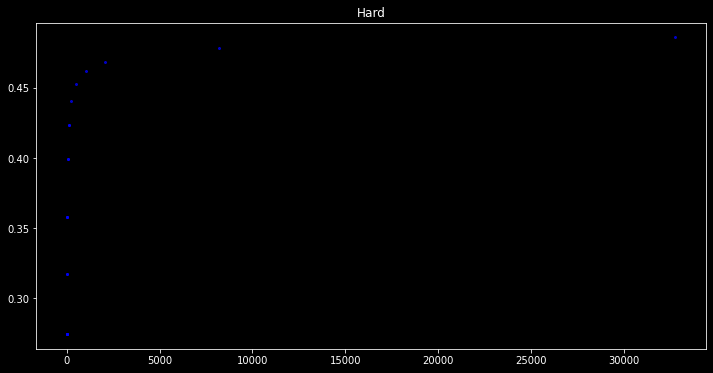

In [32]:
hurst_optimizer(nrm, simplify=1, ANIS_LLOYD=True)

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

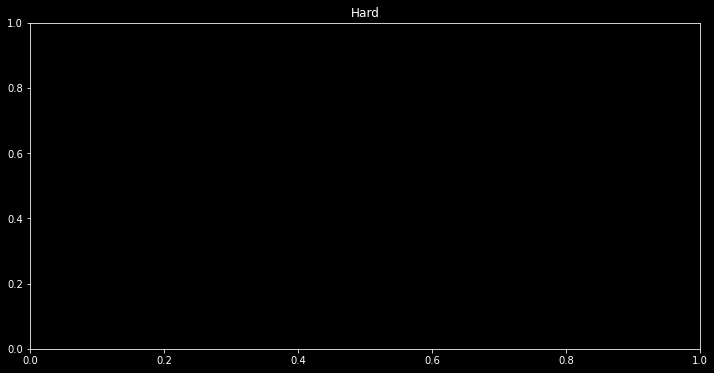

In [39]:
hurst_optimizer(nrm, simplify=3)

  0%|          | 0/182 [00:00<?, ?it/s]

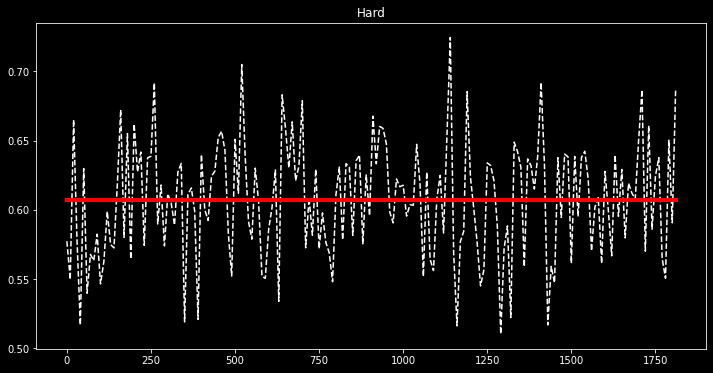

In [102]:
frame = 200
plt.figure(figsize=(12,6))
plt.title('Hard')
#   VERSION A
RESULTS = list()
for _ in tqdm(range(0, len(nrm) // frame, 10)):
    #buf_data = nrm[_* frame: (_+1)* frame]
    buf_data = np.log(nrm[_* frame: (_+1)* frame])
    #buf_data = np.diff(buf_data) / buf_data[:-1]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    RESULTS.append([_, _hurst_runner(buf_data, 1.2, ANIS_LLOYD=False)[0]])

means = np.ones(shape=len(RESULTS))
means[:] = np.mean([_[1] for _ in RESULTS])
plt.plot([_[0] for _ in RESULTS], [_[1] for _ in RESULTS], '--', color='white')
plt.plot([_[0] for _ in RESULTS], means, '-', color='red', linewidth=4)

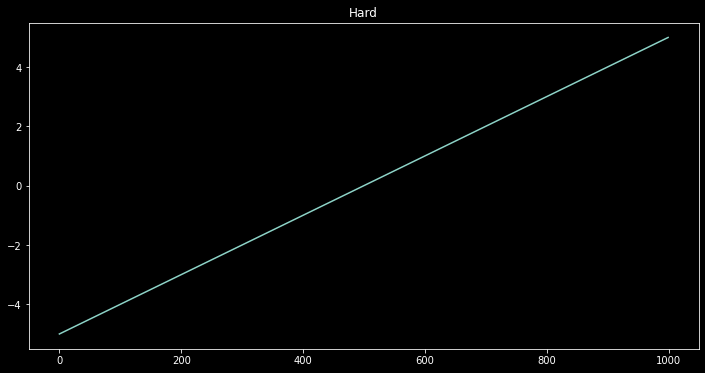

  0%|          | 0/80 [00:00<?, ?it/s]

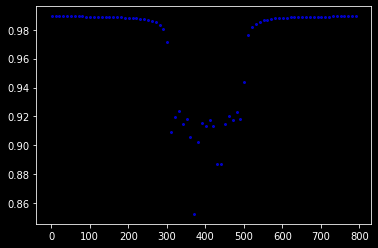

In [90]:
frame = 200
testing = np.log([np.exp(x) for x in np.linspace(-5, 5, 100_0)])
#testing = np.log(np.random.randn(sample_size) + scalar)
#testing = np.log(np.cumsum(np.random.randn(sample_size)) + scalar)
plt.figure(figsize=(12,6))
plt.title('Hard')
plt.plot(testing)
plt.show()
RESULTS = list()
for _ in tqdm(range(1, len(testing) - frame, 10)):
    buf_data = testing[_: _ + frame]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    plt.plot(_, _hurst_runner(buf_data, 1, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)

  0%|          | 0/290 [00:00<?, ?it/s]

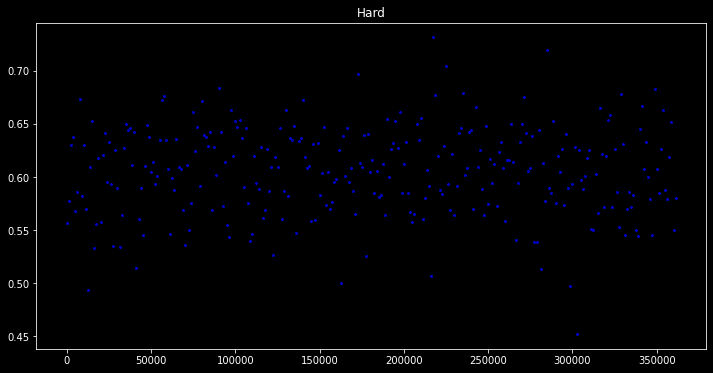

In [76]:
frame = 200
plt.figure(figsize=(12,6))
plt.title('Hard')
#   VERSION B
for _ in tqdm(range(1, len(nrm) - frame, 1250)):
    buf_data = nrm[_: _ + frame]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    RESULTS.append([_, _hurst_runner(buf_data, 1.2, ANIS_LLOYD=False)[0]])

plt.plot([_[0] for _ in RESULTS], [_[1] for _ in RESULTS], '--', color='white')

In [16]:
def printer(X, ABOBA):
    return X, X+1

Parallel(n_jobs=-1, verbose=10)(delayed(printer)(i, i+1) for i in range(10))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0085s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10)]